In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import os
import pickle
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional, Dropout, BatchNormalization
from textblob import TextBlob
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2


In [46]:

# Load the dataset
dataset_path = "/content/drive/MyDrive/Audio-Sentiment-Analysis-main/datasets/Tweets.csv"
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset to verify it's loaded correctly
print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [48]:

# Perform sentiment analysis for each incoming call
sentiments = []
for text in df['text']:
    analysis = TextBlob(str(text))  # Convert to string to handle potential NaN values
    # Determine sentiment polarity (-1 for negative, 0 for neutral, 1 for positive)
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Neutral' if analysis.sentiment.polarity == 0 else 'Negative'
    sentiments.append(sentiment)

# Add sentiment analysis results to the DataFrame
df['Sentiment'] = sentiments

# Display the DataFrame with sentiment analysis results
print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Sentiment  
0  I`d have responded, if I were going   neutral   Neutral  
1                             Sooo SAD  negative  Negative  
2                          bullying me  negative   Neutral  
3                       leave me alone  negative   Neutral  
4                        Sons of ****,  negative   Neutral  


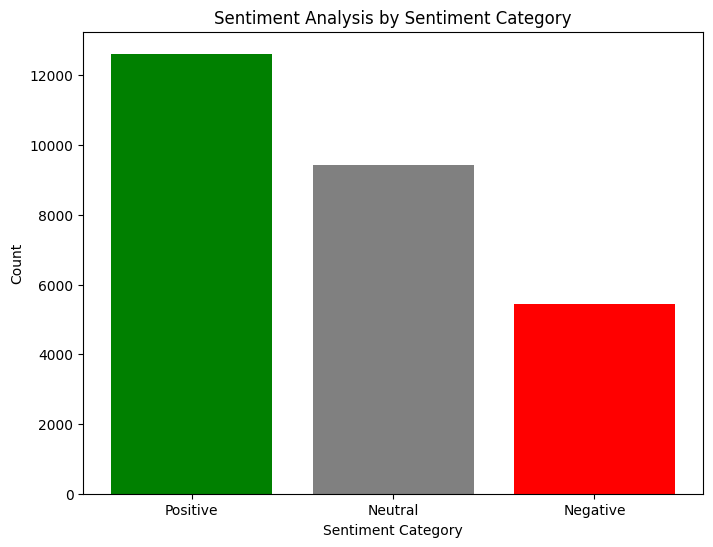

In [54]:
import matplotlib.pyplot as plt

# Data
sentiment_counts = {'Positive': 12619, 'Neutral': 9427, 'Negative': 5434}

# Plot
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'grey', 'red'])
plt.title('Sentiment Analysis by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


In [56]:
# Get the sentiment category counts from the 'Sentiment' column
sentiment_category_counts = df['Sentiment'].value_counts()

# Print the counts
print("Sentiment Analysis by Sentiment Category:\n", sentiment_category_counts)


Sentiment Analysis by Sentiment Category:
 Sentiment
Positive    12619
Neutral      9428
Negative     5434
Name: count, dtype: int64


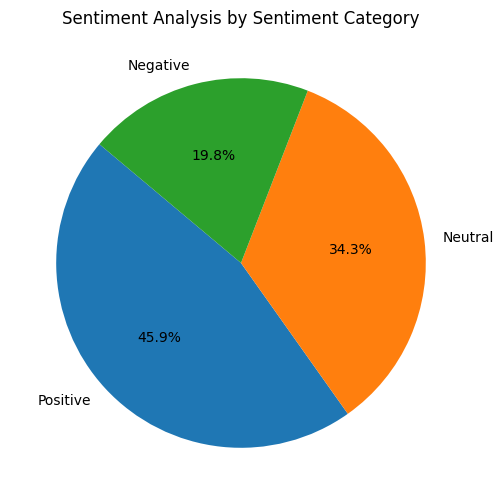

In [57]:
import matplotlib.pyplot as plt

# Define the sentiment counts
sentiment_counts = {
    'Positive': 12619,
    'Neutral': 9427,
    'Negative': 5434
}

# Plotting pie chart for sentiment analysis results
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis by Sentiment Category')
plt.show()

In [58]:


# Split the dataset into training and testing sets
X = df['text'].astype(str).values  # Convert to string
y = pd.get_dummies(df['sentiment']).values  # Convert sentiment labels to one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

# Define number of epochs as an integer
epochs = 100  # or any integer value you desire

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Build LSTM model with dropout and L2 regularization
embedding_dim = 128
lstm_out = 128

# Define the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.5))  # Increased dropout rate
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))  # Added L2 regularization
model.add(Dense(3, activation='softmax'))  # 3 classes: Positive, Neutral, Negative
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping and model checkpoint
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=epochs, batch_size=32, verbose=1, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score = model.evaluate(X_test_pad, y_test, batch_size=32, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# Print training and validation accuracy
print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")


# Specify the directory path where you want to save the tokenizer
save_dir = '/content/drive/MyDrive/Audio-Sentiment-Analysis-main/model_files'

# Ensure that the directory exists, create it if it doesn't
os.makedirs(save_dir, exist_ok=True)

# Save the tokenizer
tokenizer_path = os.path.join(save_dir, 'tokenizer.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Tokenizer saved at: {tokenizer_path}")




Epoch 1/100
687/687 [==============================] - 212s 305ms/step - loss: 1.0456 - accuracy: 0.5382 - val_loss: 0.8016 - val_accuracy: 0.6704
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


687/687 [==============================] - 210s 306ms/step - loss: 0.7774 - accuracy: 0.6816 - val_loss: 0.7385 - val_accuracy: 0.6977
Epoch 3/100
687/687 [==============================] - 211s 307ms/step - loss: 0.7077 - accuracy: 0.7227 - val_loss: 0.7273 - val_accuracy: 0.7062
Epoch 4/100
687/687 [==============================] - 209s 304ms/step - loss: 0.6608 - accuracy: 0.7426 - val_loss: 0.7196 - val_accuracy: 0.7160
Epoch 5/100
687/687 [==============================] - 217s 316ms/step - loss: 0.6412 - accuracy: 0.7513 - val_loss: 0.7214 - val_accuracy: 0.7142
Epoch 6/100
687/687 [==============================] - 212s 309ms/step - loss: 0.6150 - accuracy: 0.7638 - val_loss: 0.7235 - val_accuracy: 0.7222
Epoch 7/100
687/687 [==============================] - 209s 304ms/step - loss: 0.6035 - accuracy: 0.7699 - val_loss: 0.7106 - val_accuracy: 0.7235
Epoch 8/100
687/687 [==============================] - 208s 303ms/step - loss: 0.5852 - accuracy: 0.7802 - val_loss: 0.7567 - val_

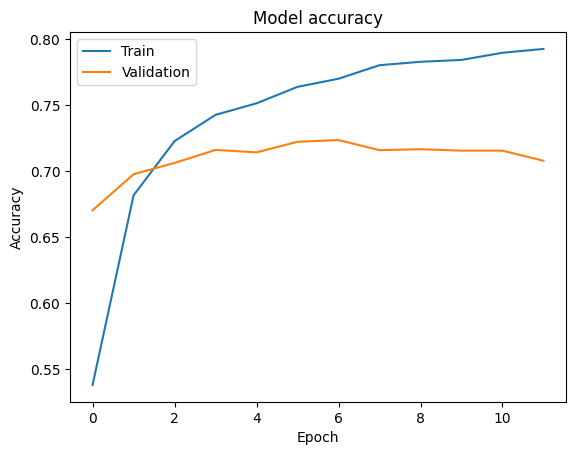

In [59]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




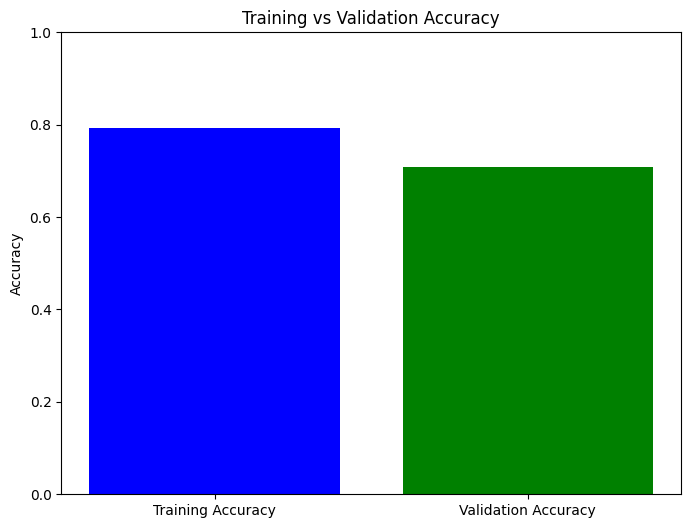

In [60]:
import matplotlib.pyplot as plt

# Get the final training and validation accuracy
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [training_accuracy, validation_accuracy], color=['blue', 'green'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()


In [61]:


# Load the text data you want to predict sentiment for
text_data = ["This is a great movie!",
             "I'm not sure how I feel about this.",
             "I hated the ending of that book."]

# Tokenize the text
max_len = 100
X_sequences = tokenizer.texts_to_sequences(text_data)
X_pad = pad_sequences(X_sequences, maxlen=max_len)

# Load the saved model architecture
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model weights
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_weights.h5")

# Predict sentiment
predictions = loaded_model.predict(X_pad)

# Decode predictions
sentiments = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
decoded_predictions = [sentiments[np.argmax(pred)] for pred in predictions]

# Print predictions
for text, pred in zip(text_data, decoded_predictions):
    print(f"Text: {text} \nPredicted Sentiment: {pred}\n")


1/1 [==============================] - 0s 366ms/step
Text: This is a great movie! 
Predicted Sentiment: Positive

Text: I'm not sure how I feel about this. 
Predicted Sentiment: Negative

Text: I hated the ending of that book. 
Predicted Sentiment: Negative



In [64]:
from keras.models import model_from_json

# Load the JSON model architecture
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model architecture from JSON
loaded_model = model_from_json(loaded_model_json)

# Load the weights into the model
loaded_model.load_weights("model_weights.h5")

# Print the summary of the loaded model
print(loaded_model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          640000    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 100, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 771971 (2.94 MB)
Trainable params: 771971 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


************************************ **THANK** YOU ********************





You're welcome! I'm glad I could help.
